![quanda_benchmarks_demo.png](attachment:quanda_benchmarks_demo.png)

In this notebook, we will go through the different ways of creating an evaluation benchmark and comparing different attributors with it. First, we take the most straightforward route and go over the process of downloading a precomputed quanda benchmark for data attribution evaluation. This way, you can quickly write a quanda wrapper for your explainer and evaluate it against the existing explainers in the controlled setups we have prepared for you.

Afterwards, we will go through the steps of assembling a benchmark from existing components. This option allows you to create your own controlled setup, and use quanda benchmarks for evaluation of different data attributors.

Finally, we will summarize how to create your setup using quanda benchmarks, which includes managing datasets, training models and running evaluations.

Throughout this tutorial, we will be using a LeNet model trained on the MNIST dataset.

We first handle our include statements.

In [27]:
import os
import sys

sys.path.append("/home/yolcu/Documents/Code/quanda")

import torch
import torchvision
from quanda.benchmarks.downstream_eval import ShortcutDetection
from quanda.explainers.wrappers import (
    TRAK,
    CaptumArnoldi,
    CaptumSimilarity,
    CaptumTracInCPFast,
    RepresenterPoints,
)



In [28]:
torch.set_float32_matmul_precision("medium")
to_img = torchvision.transforms.Compose([
    torchvision.transforms.Normalize(mean=0.0, std=2.),
    torchvision.transforms.Normalize(mean=-0.5, std=1.),
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize((224, 224)),])

# Downloading Precomputed Benchmarks
In this part of the tutorial, we will use the Shortcut Detection metric.

We will use the benchmark corresponding to this metric to evaluate all data attributors currently included in quanda in terms of their ability to detect when the model is using a shortcut.

We will download the precomputed MNIST benchmark. This includes an MNIST dataset which has shortcut features (an 8-by-8 white box on a specific location) on a subset of its samples from the class 0, and a model trained on this dataset. This model has learned to classify images with these features to the class 0, and we will measure the extent to which this is reflected in the attributions of different methods.

In [29]:
cache_dir = str(os.path.join(os.getcwd(), "quanda_benchmark_tutorial_cache"))
device="cuda"
benchmark = ShortcutDetection.download(
    name="mnist_shortcut_detection",
    cache_dir=cache_dir,
    device=device,
)

/home/yolcu/Documents/Code/quanda/quanda/benchmarks/base.py:88: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(os.path.join(cache_dir, name + ".pth"), map_l

The benchmark object contains all information about the controlled evaluation setup. Let's see some samples with the shortcut features, using benchmark.feature_dataset and benchmark.shortcut_indices. 

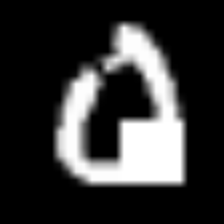

In [30]:
shortcut_img = benchmark.shortcut_dataset[benchmark.shortcut_indices[15]][0]
tensor_img=torch.concat([shortcut_img,shortcut_img,shortcut_img],dim=0)
img=to_img(tensor_img)
img

In [31]:
predictions = []
for i in benchmark.shortcut_indices:
    x,y = benchmark.shortcut_dataset[i]
    x=x.to(device)
    benchmark.model(x[None])
    predictions.append(benchmark.model(x[None]).argmax().item())
predictions=torch.tensor(predictions)
shortcut_rate=torch.mean((predictions==benchmark.shortcut_cls)*1.0)
shortcut_rate

tensor(0.9986)

## Prepare initialization parameters for TDA methods

We now prepare the initialization parameters of attributors: hyperparameters, and components from the benchmark as needed. Note that we do not provide the model and dataset to use for attribution, since those components will be supplied by the benchmark objects, while initializing the attributor during evaluation.

### Similarity Influence

In [32]:
captum_similarity_args = {
    "model_id": "mnist_shortcut_detection_tutorial",
    "layers": "model.fc_2",
    "cache_dir": os.path.join(cache_dir, "captum_similarity"),
}

### Arnoldi Influence Functions

Notice that the trained checkpoints have been saved to the `cache_dir` while downloading the benchmark. We can reach the paths of these checkpoints with `benchmark.checkpoint_paths`

In [33]:
hessian_num_samples=500 # number of samples to use for hessian estimation
hessian_ds=torch.utils.data.Subset(benchmark.shortcut_dataset, torch.randint(0, len(benchmark.shortcut_dataset), (hessian_num_samples,)))

captum_influence_args = {
        "checkpoint": benchmark.checkpoint_paths[-1],
        "layers": ["model.fc_3"],
        "batch_size": 8,
        "hessian_dataset": hessian_ds,
        "projection_dim": 5,
}

### TracInCP

In [34]:
captum_tracin_args = {
    "final_fc_layer": "model.fc_3",
    "loss_fn": torch.nn.CrossEntropyLoss(reduction="mean"),
    "checkpoints": benchmark.checkpoint_paths,
    "batch_size": 8,
}

### TRAK

In [35]:
trak_args = {
    "model_id": "mnist_shortcut_detection",
    "cache_dir": os.path.join(cache_dir, "trak"),
    "batch_size": 8,
    "proj_dim": 5,
}

### Representer Points Selection

In [36]:
representer_points_args = {
    "model_id": "mnist_shortcut_detection",
    "cache_dir": os.path.join(cache_dir, "representer_points"),
    "batch_size": 8,
    "features_layer": "model.relu_4",
    "classifier_layer": "model.fc_3",
}

## Run the benchmark evaluation on the attributors
Note that some attributors take a long time to initialize or compute attributions. For a proof of concept, we recommend using `CaptumSimilarity` or `RepresenterPoints`, or lowering the parameter values given above (i.e. using low `proj_dim` for TRAK or a low Hessian dataset size for Arnoldi Influence)

In [39]:
attributors={
    # please comment out the explainers you are not interested in
    #"captum_similarity": (CaptumSimilarity, captum_similarity_args),
    #"captum_arnoldi" : (CaptumArnoldi, captum_influence_args),
    #"captum_tracin" : (CaptumTracInCPFast, captum_tracin_args),
    "trak" : (TRAK, trak_args),
    #"representer" : (RepresenterPoints, representer_points_args),
}

In [46]:
results=dict()
for name, (cls, kwargs) in attributors.items():
    results[name] = benchmark.evaluate(
        explainer_cls=cls,
        expl_kwargs=kwargs,
        batch_size=128
    )["score"]

2024-09-28 17:52:36,774 - root - INFO - Initializing TRAK explainer...
2024-09-28 17:52:36,808 - STORE - INFO - Existing model IDs in /home/yolcu/Documents/Code/quanda/tutorials/quanda_benchmark_tutorial_cache/trak: [0]
2024-09-28 17:52:36,810 - STORE - INFO - Model IDs that have been finalized: [0]
2024-09-28 17:52:36,811 - STORE - INFO - No existing TRAK scores in /home/yolcu/Documents/Code/quanda/tutorials/quanda_benchmark_tutorial_cache/trak.
Metric evaluation, batch 1/1:   0%|          | 0/1 [01:06<?, ?it/s]


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

The `results` dictionary contains the results of the evaluation. The keys are the names of the explainers and the values are dictionaries containing the results.

In [ ]:
results

# Assembling a benchmark from existing components

You may want to handle the creation of each component differently, using different datasets, architectures, training paradigms or a higher/lower percentage of manipulated samples. We now showcase how to create and use a quanda `Benchmark` object to use these components in the evaluation process.

To showcase different benchmarks, we will now switch to the `MislabelingDetection` benchmark. This benchmark evaluates the ability of data atttribution methods to identify mislabeled samples in the training dataset. This is done by ranking the training data using local attributors. Original papers propose either using self-influence (i.e. the attribution of training samples on themselves) or some special methodology for each explainer (i.e. the global coefficients of the surrogate model in Representer Points). Quanda includes efficient implementation of self-influence or other strategies proposed in the original papers, whenever possible.

Instead of creating the components from scratch, we will again download the benchmark and use collect the prepared components. We will then use the `MislabelingDetection.assemble` method to create the benchmark. Note that this is exactly what is happening when we are creating a benchmark using the `download` method.

In [45]:
device

'cuda'